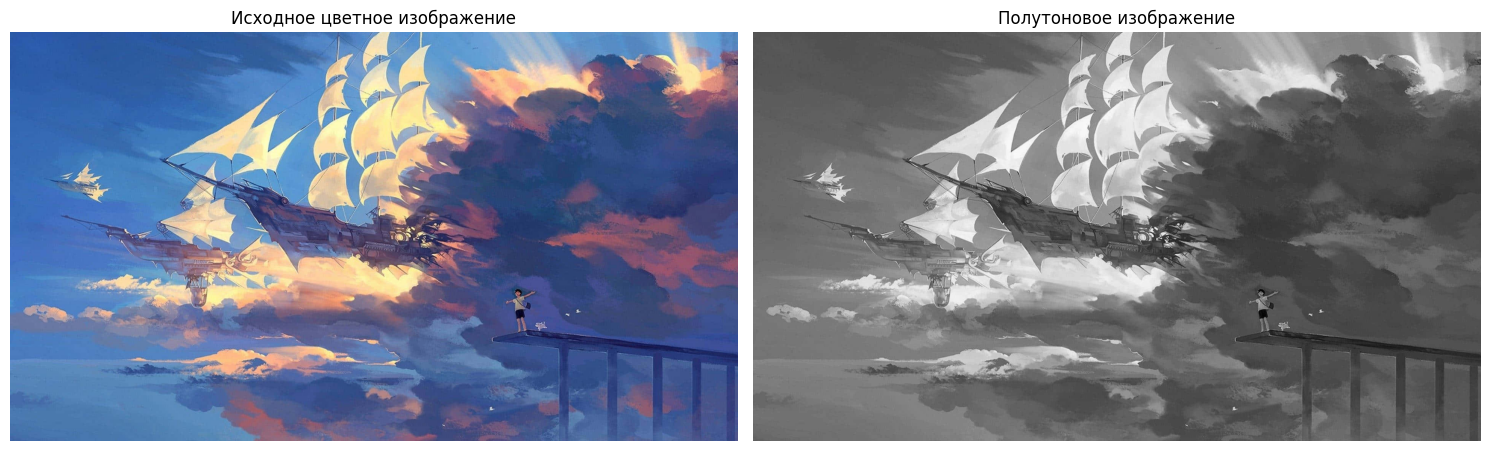

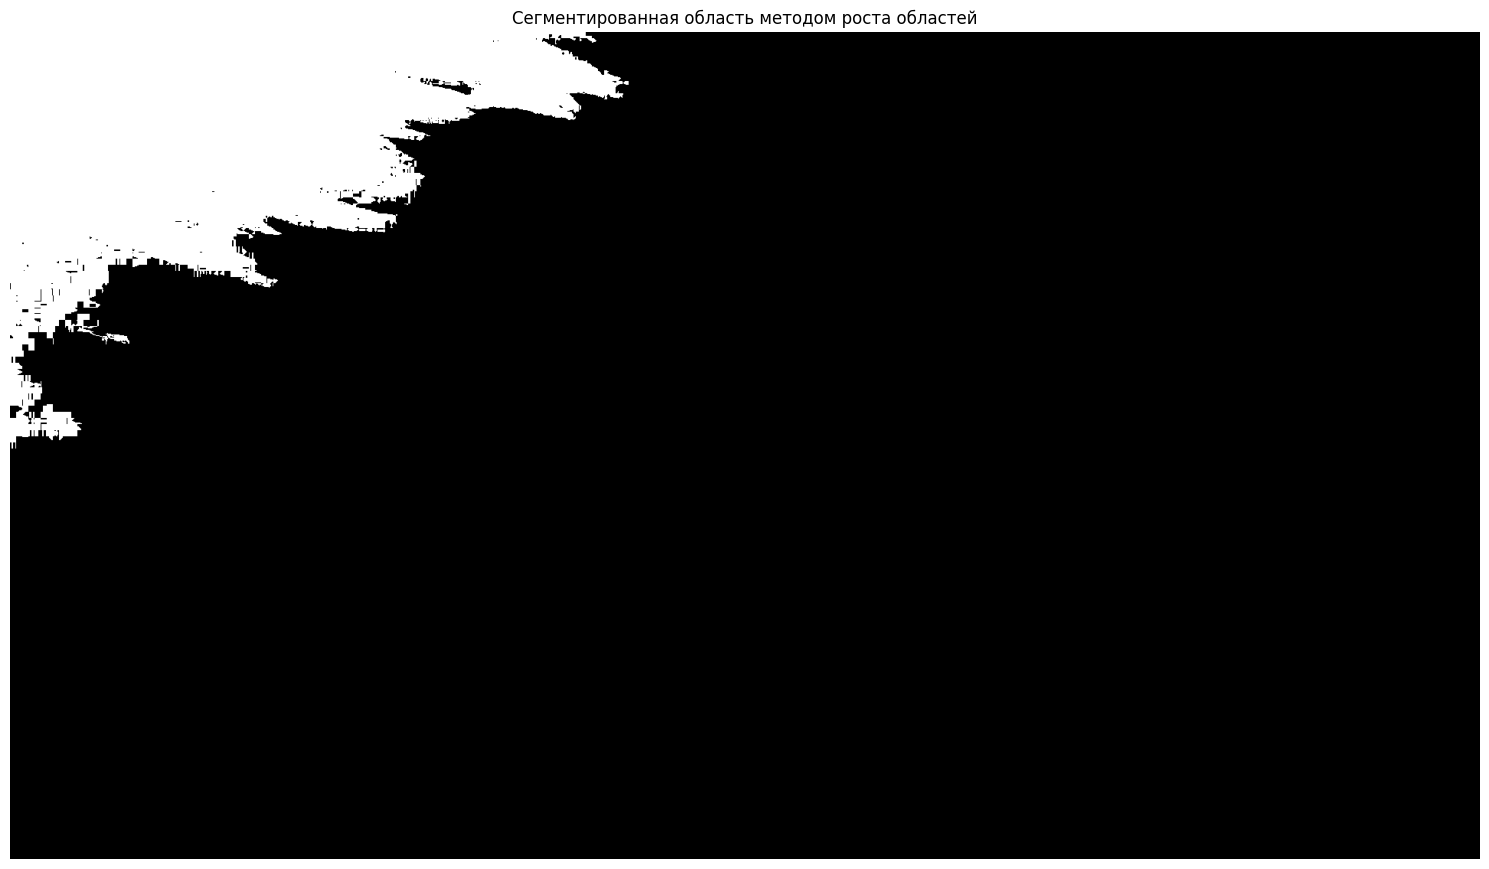

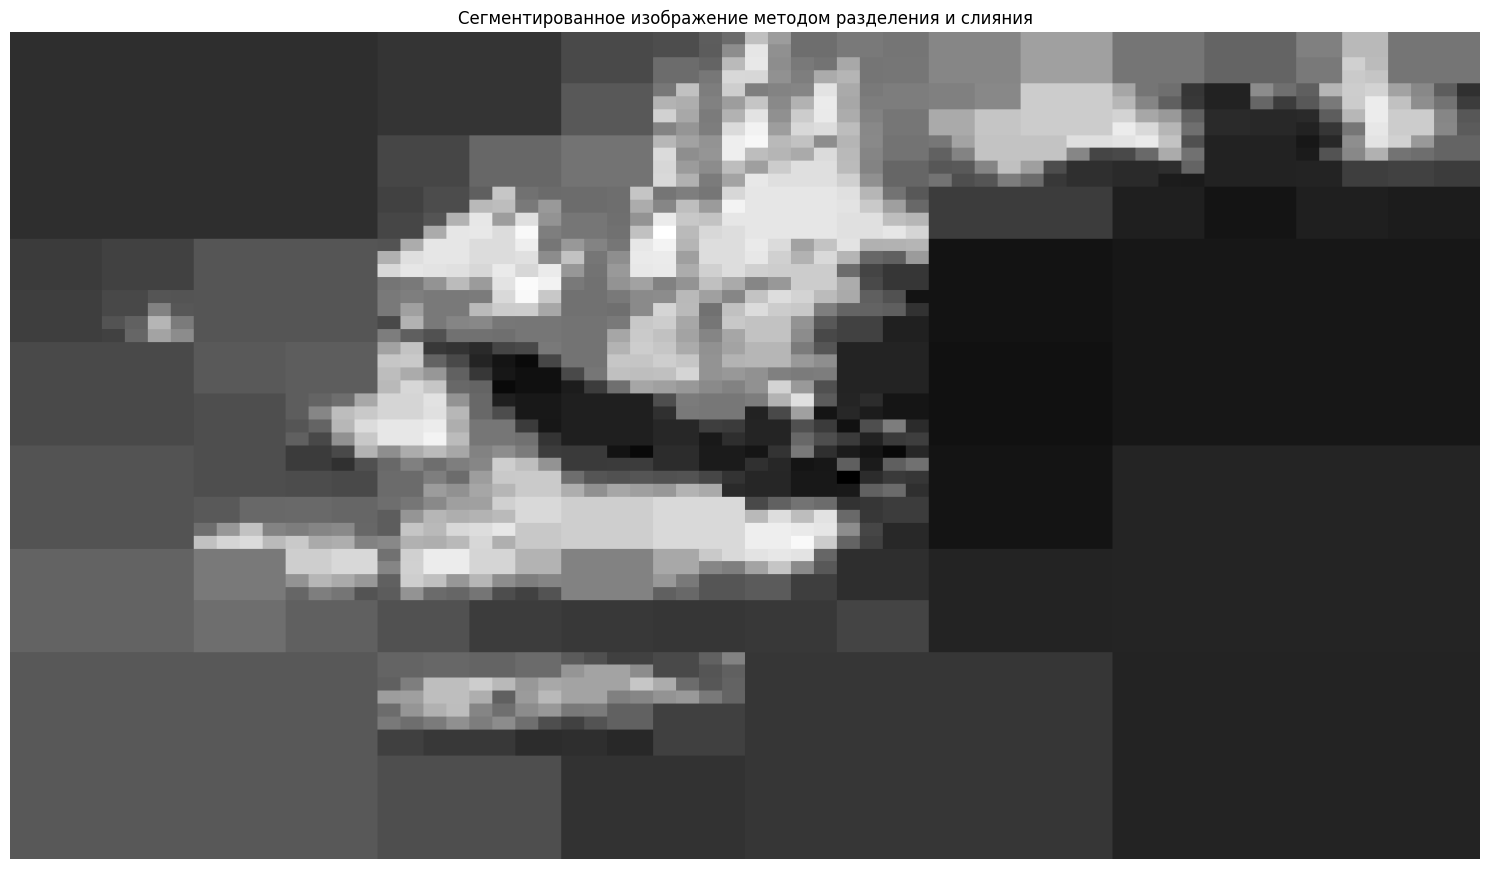

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def load_image(image_path):
    """
    Загружает изображение и конвертирует его в оттенки серого.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Изображение по пути {image_path} не найдено.")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image, gray

def show_images(images, titles, figsize=(15, 10)):
    """
    Отображает несколько изображений в одном окне.
    """
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def region_growing(gray, seed, threshold):
    """
    Реализует метод роста областей для сегментации изображения.
    
    :param gray: Полутоновое изображение.
    :param seed: Начальная точка (x, y).
    :param threshold: Порог схожести.
    :return: Маска сегментированной области.
    """
    rows, cols = gray.shape
    segmented = np.zeros_like(gray, dtype=np.uint8)
    visited = np.zeros_like(gray, dtype=bool)
    queue = deque()
    queue.append(seed)
    visited[seed[1], seed[0]] = True
    segmented[seed[1], seed[0]] = 255
    reference_intensity = gray[seed[1], seed[0]]
    
    while queue:
        x, y = queue.popleft()
        # Исследуем 8-связные соседей
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                nx, ny = x + dx, y + dy
                if (0 <= nx < cols) and (0 <= ny < rows) and not visited[ny, nx]:
                    current_intensity = gray[ny, nx]
                    if abs(int(current_intensity) - int(reference_intensity)) <= threshold:
                        segmented[ny, nx] = 255
                        queue.append((nx, ny))
                    visited[ny, nx] = True
    return segmented

def split_and_merge(image, threshold, min_size=30):
    """
    Реализует метод разделения и слияния для сегментации изображения.
    
    :param image: Полутоновое изображение.
    :param threshold: Порог схожести.
    :param min_size: Минимальный размер региона для прекращения разделения.
    :return: Маска сегментированной области.
    """
    rows, cols = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    
    def is_homogeneous(region):
        mean = np.mean(region)
        variance = np.var(region)
        return variance <= threshold
    
    def split(image, x, y, w, h):
        """
        Рекурсивно разделяет область на квадранты.
        """
        region = image[y:y+h, x:x+w]
        if is_homogeneous(region) or w <= min_size or h <= min_size:
            mean = int(np.mean(region))
            segmented[y:y+h, x:x+w] = mean
        else:
            w2, h2 = w // 2, h // 2
            split(image, x, y, w2, h2)
            split(image, x + w2, y, w - w2, h2)
            split(image, x, y + h2, w2, h - h2)
            split(image, x + w2, y + h2, w - w2, h - h2)
    
    split(image, 0, 0, cols, rows)
    return segmented

# Путь к изображению
image_path = '../images/IMG_20130818_081052.jpg'

# Загрузка изображения
color_image, gray_image = load_image(image_path)

# Отображение исходных изображений
show_images(
    [color_image, gray_image],
    ['Исходное цветное изображение', 'Полутоновое изображение']
)

# Метод роста областей
seed_point = (100, 100)  # Начальная точка (x, y)
threshold = 15  # Порог схожести
segmented_region = region_growing(gray_image, seed_point, threshold)

# Отображение результата метода роста областей
show_images(
    [segmented_region],
    ['Сегментированная область методом роста областей']
)

# Метод разделения и слияния
split_merge_threshold = 500  # Порог вариации для разделения
segmented_split_merge = split_and_merge(gray_image, split_merge_threshold)

# Отображение результата метода разделения и слияния
show_images(
    [segmented_split_merge],
    ['Сегментированное изображение методом разделения и слияния']
)